In [1]:
!pip install SentencePiece


In [2]:
!pip install datasets

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/20
2663/2663 [==============================] - 1299s 474ms/step - loss: 0.8454 - accuracy: 0.5363 - val_loss: 0.6864 - val_accuracy: 0.6515

Epoch 2/20
2663/2663 [==============================] - 1263s 474ms/step - loss: 0.6336 - accuracy: 0.7013 - val_loss: 0.5795 - val_accuracy: 0.7376

Epoch 3/20
2663/2663 [==============================] - 1263s 474ms/step - loss: 0.5446 - accuracy: 0.7545 - val_loss: 0.4743 - val_accuracy: 0.7938

Epoch 4/20
2663/2663 [==============================] - 1264s 475ms/step - loss: 0.4618 - accuracy: 0.8032 - val_loss: 0.4325 - val_accuracy: 0.8150

Epoch 5/20
2663/2663 [==============================] - 1264s 475ms/step - loss: 0.3889 - accuracy: 0.8401 - val_loss: 0.4260 - val_accuracy: 0.8273

Epoch 6/20
2663/2663 [==============================] - 1263s 474ms/step - loss: 0.3201 - accuracy: 0.8728 - val_loss: 0.3738 - val_accuracy: 0.8546

Epoch 7/20
2663/2663 [==============================] - 1260s 473ms/step - loss: 0.2754 - accuracy:

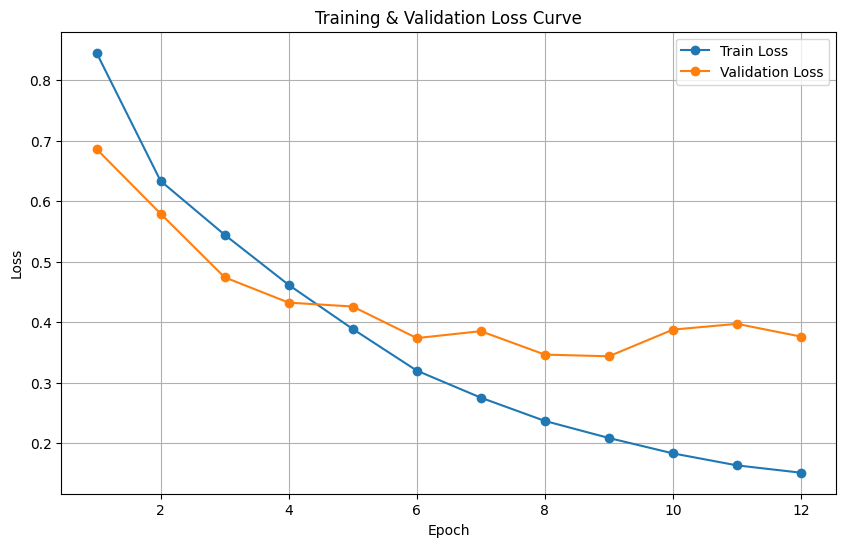

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFXLMRobertaForSequenceClassification

# Load the dataset (adjust the path as needed)
csv_path = "/kaggle/input/product-dataset/balanced_dataset.csv"
dataframe = pd.read_csv(csv_path)

# Combine columns into a single text input for the model
dataframe["text"] = (
    dataframe["Product Name"] + " [SEP] " +
    dataframe["Rating"].astype(str) + " [SEP] " +
    dataframe["Review"] + " [SEP] " +
    dataframe["Product Category"] + " [SEP] " +
    dataframe["Data Source"] + " [SEP] " +
    dataframe["Sentiment"]
)

# Drop unnecessary columns
columns_to_remove = ['Rating', 'Product Name', 'Product Category', 'Data Source', 'Review', 'Sentiment']  # remove sentiment
dataframe = dataframe.drop(columns=columns_to_remove)

# Label encoding for emotions
label_mapping = {"Happy": 0, "Love": 1, "Sadness": 2, "Anger": 3, "Fear": 4}
dataframe['label'] = dataframe['Emotion'].map(label_mapping)

# Split data (70% train, 20% test, 10% validation)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataframe['text'], dataframe['label'], test_size=0.3, random_state=42, stratify=dataframe['label'])

val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=(2/3), random_state=42, stratify=test_labels)

# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

def tokenize_texts(text_list):
    return tokenizer(list(text_list), padding='max_length', truncation=True, max_length=128, return_tensors='tf')

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels.tolist()))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels.tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels.tolist()))

# Model
model = TFXLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=5)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Training with Early Stopping (manual loop)
batch_size = 16
train_batches = train_dataset.shuffle(3000).batch(batch_size)
val_batches = val_dataset.batch(batch_size)

num_epochs = 20
early_stopping_patience = 3
best_val_loss = float('inf')
stopping_counter = 0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    history = model.fit(train_batches, epochs=1, batch_size=batch_size, validation_data=val_batches, verbose=1)

    avg_train_loss = np.mean(history.history['loss'])
    avg_val_loss = np.mean(history.history['val_loss'])

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        stopping_counter = 0
    else:
        stopping_counter += 1
        if stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Evaluate on test set
test_batches = test_dataset.batch(batch_size)
eval_results = model.evaluate(test_batches)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss', marker='o')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training & Validation Loss Curve')
plt.show()


761/761 [==============================] - 113s 146ms/step
Classification Report:

              precision    recall  f1-score   support

       Happy       0.87      0.85      0.86      4127
        Love       0.86      0.87      0.86      4127
     Sadness       0.93      0.85      0.89      1306
       Anger       0.87      0.95      0.91      1307
        Fear       0.95      0.97      0.96      1307

    accuracy                           0.88     12174
   macro avg       0.90      0.90      0.90     12174
weighted avg       0.88      0.88      0.88     12174



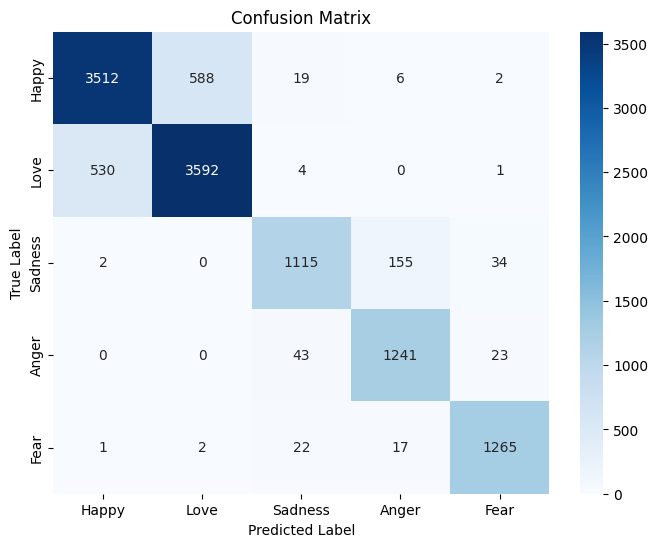

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_true = test_labels.tolist()

y_pred_logits = model.predict(test_batches).logits
y_pred = np.argmax(y_pred_logits, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
